# Visualise Trajectories with Loops

<a id='toc'></a>

In [1]:
% matplotlib inline

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from fastkml import kml, styles
from shapely.geometry import Point, LineString

In [2]:
dir_ijcai = 'data/data-ijcai15'
dir_recsys = 'data/data-recsys16'

In [3]:
#fvisit = os.path.join(dir_ijcai, 'userVisits-Osak.csv')
#fcoord = os.path.join(dir_ijcai, 'photoCoords-Osak.csv')
#fvisit = os.path.join(dir_ijcai, 'userVisits-Glas.csv')
#fcoord = os.path.join(dir_ijcai, 'photoCoords-Glas.csv')
fvisit = os.path.join(dir_ijcai, 'userVisits-Edin.csv')
fcoord = os.path.join(dir_ijcai, 'photoCoords-Edin.csv')
#fvisit = os.path.join(dir_ijcai, 'userVisits-Toro.csv')
#fcoord = os.path.join(dir_ijcai, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]

In [5]:
fpoi = os.path.join(dir_recsys, 'poi-' + suffix + '.csv')
ftraj_all = os.path.join(dir_recsys, 'traj-all-' + suffix + '.csv')

<a id='sec1'></a>

## 1. Load Data

Load user visit data and photo coordinates.

In [6]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
visits = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'

In [7]:
visits.head()

,photoID,userID,dateTaken,poiID,poiTheme,poiFreq,seqID,photoLon,photoLat
0,7941504100,10007579@N00,1346844688,30,Structure,1538,1,-79.380844,43.645641
1,4886005532,10012675@N05,1142731848,6,Cultural,986,2,-79.391525,43.654335
2,4886006468,10012675@N05,1142732248,6,Cultural,986,2,-79.391525,43.654335
3,4885404441,10012675@N05,1142732373,6,Cultural,986,2,-79.391525,43.654335
4,4886008334,10012675@N05,1142732445,6,Cultural,986,2,-79.391525,43.654335


In [8]:
num_photo = visits.shape[0]
num_user = visits['userID'].unique().shape[0]
num_poi = visits['poiID'].unique().shape[0]
num_traj = visits['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#traj': num_traj, \
              '#photo/user': num_photo/num_user, '#traj/user': num_traj/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#traj,#traj/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


<a id='sec2'></a>

## 2. Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [9]:
poi_coords = visits[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category.

In [10]:
poi_cat = visits[['poiID', 'poiTheme']].groupby('poiID').first()
poi_cat.reset_index(inplace=True)

In [11]:
poi_all = pd.merge(poi_cat, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.rename(columns={'poiTheme':'poiCat'}, inplace=True)

In [12]:
poi_all.head()

,poiCat,poiLon,poiLat
poiID,,,
1,Sport,-79.379243,43.643183
2,Sport,-79.418634,43.632772
3,Sport,-79.380045,43.662175
4,Sport,-79.389290,43.641297
6,Cultural,-79.392396,43.653662


Scatter plot of POI coordinates.

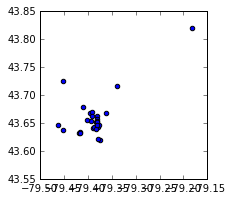

In [13]:
height = 3
ratio = (poi_all['poiLon'].max() - poi_all['poiLon'].min()) / (poi_all['poiLat'].max() - poi_all['poiLat'].min())
plt.figure(figsize=[height * np.round(ratio), height])
plt.scatter(poi_all['poiLon'], poi_all['poiLat'])

<a id='sec3'></a>

## 3. Visualise Trajectories with Loops

Compute trajectories information including simple statistics such as length (#POIs), POI start time, POI endtime, etc.

In [14]:
def calc_traj_df(seqid, visits):
    """Compute trajectories info, taking care of trajectories that contain sub-tours"""
    traj_df = visits[visits['seqID'] == seqid].copy()
    traj_df.sort_values(by='dateTaken', ascending=True, inplace=True)
    df_ = pd.DataFrame(columns=['poiID', 'startTime', 'endTime', '#photo'])
    assert(traj_df.shape[0] > 0)
    ix = traj_df.index[0]
    j = 0
    df_.loc[j] = [traj_df.loc[ix, 'poiID'], traj_df.loc[ix, 'dateTaken'], traj_df.loc[ix, 'dateTaken'], 1]
    for i in range(1, traj_df.shape[0]):
        ix = traj_df.index[i]
        if traj_df.loc[ix, 'poiID'] == df_.loc[j, 'poiID']:
            df_.loc[j, 'endTime'] = traj_df.loc[ix, 'dateTaken']
            df_.loc[j, '#photo'] += 1
        else:
            j += 1
            df_.loc[j] = [traj_df.loc[ix, 'poiID'], traj_df.loc[ix, 'dateTaken'], traj_df.loc[ix, 'dateTaken'], 1]
    df_['userID'] = traj_df.loc[traj_df.index[0], 'userID']
    df_['trajID'] = seqid
    df_['trajLen'] = df_.shape[0]
    return df_

Trajectories with loops/sub-tours.

In [17]:
for tid in visits['seqID'].unique():
    t = calc_traj_df(tid, visits)
    t = t['poiID'].astype(np.int).tolist()
    if len(t) != len(set(t)): 
        print(tid, ':', t)

67 : [28, 23, 22, 28]
103 : [30, 7, 30]
113 : [30, 7, 30]
139 : [3, 23, 22, 30, 22]
157 : [27, 23, 11, 27]
171 : [28, 22, 28, 22]
230 : [16, 8, 16]
239 : [21, 23, 21]
294 : [16, 8, 16, 30]
298 : [22, 7, 23, 28, 1, 29, 30, 8, 29, 6, 28, 23, 30, 11, 24, 22, 29, 4, 16, 8, 30]
315 : [16, 4, 16, 8, 16]
316 : [21, 27, 11, 27, 11]
384 : [22, 28, 22, 28, 22, 28]
453 : [23, 28, 16, 28]
454 : [16, 21, 23, 16, 8, 16, 8, 16, 8, 16, 28, 22, 28, 23, 27]
514 : [16, 4, 16]
524 : [25, 19, 15, 19]
525 : [22, 8, 30, 7, 28, 22, 28, 23, 21, 30, 7, 8, 16, 21, 30, 21, 30, 21]
533 : [16, 8, 16]
544 : [7, 30, 8, 7]
549 : [22, 1, 8, 21, 22, 28, 22]
550 : [1, 21, 1]
634 : [22, 28, 23, 28, 22]
675 : [22, 6, 25, 6]
681 : [23, 28, 16, 24, 4, 8, 30, 8, 16, 24]
686 : [22, 30, 7, 1, 8, 16, 1, 21]
687 : [7, 16, 4, 8, 4, 16]
708 : [7, 23, 28, 23, 21, 30, 7]
722 : [7, 22, 23, 22]
729 : [23, 21, 22, 7, 28, 23]
733 : [23, 21, 23, 21]
741 : [21, 23, 21]
758 : [30, 1, 30]
782 : [7, 30, 7]
786 : [7, 23, 21, 28, 7]
799 : [7, 3

In [ ]:
SEQ_ID = 687
visits[visits['seqID'] == SEQ_ID]

In [64]:
def visualise_traj(tid, poi_all, visits):
    k = kml.KML()
    ns = '{http://www.opengis.net/kml/2.2}'
    tdf = visits[visits['seqID'] == tid].copy()
    tdf.sort_values(by='dateTaken', ascending=True, inplace=True)
    t = tdf['poiID'].astype(np.int).tolist()
    traj = [t[0]]
    for poi in t[1:]: 
        if poi != traj[-1]: traj.append(poi)
    
    # Styles
    #stys = []
    #for width in width_set:
    #    sid = 'sty' + str(width)
    #    # colors in KML: aabbggrr, aa=00 is fully transparent
    #    stys.append(styles.Style(id=sid, styles=[styles.LineStyle(color='3f0000ff', width=width)])) # transparent red
    pm_list = []
    
    # draw trajectory
    for i in range(len(traj)-1):
        poi1 = traj[i]
        poi2 = traj[i+1]
        sid = str(poi1) + '->' + str(poi2)
        desc = 'POI_' + str(poi1) + ' -> ' + 'POI_' + str(poi2)
        pm = kml.Placemark(ns, sid, sid, desc)
        pm.geometry = LineString([(poi_all.loc[x, 'poiLon'], poi_all.loc[x, 'poiLat']) for x in [poi1, poi2]])
        pm_list.append(pm)
        
    # draw POIs
    for poi in traj:
        sid = str(poi)
        desc = 'POI: ' + str(poi) + ', Category: ' + poi_all.loc[poi, 'poiCat']
        pm = kml.Placemark(ns, sid, 'POI_' + str(poi), desc)
        pm.geometry = Point(poi_all.loc[poi, 'poiLon'], poi_all.loc[poi, 'poiLat'])
        pm_list.append(pm)
    
    # draw photos
    for ix in tdf.index:
        sid = str(tdf.loc[ix, 'photoID'])
        poi = int(tdf.loc[ix, 'poiID'])
        time = datetime.fromtimestamp(visits.loc[ix, 'dateTaken']).strftime('%Y-%m-%d %H:%M:%S')
        desc = 'Photo: ' + sid + ', POI: ' + str(poi) + ', Date: ' + time
        pm = kml.Placemark(ns, sid, 'PHOTO_POI_' + str(poi), desc)
        pm.geometry = Point(visits.loc[ix, 'photoLon'], visits.loc[ix, 'photoLat'])
        pm_list.append(pm)
        
    doc = kml.Document(ns, '1', 'Trajectory ' + str(tid) + ': ' + str(traj), 'Trajectory visualization')
    for pm in pm_list: doc.append(pm)
    k.append(doc)
    
    # save to file
    fname = 'traj_' + str(tid) + '.kml'
    kmlstr = k.to_string(prettyprint=True)
    with open(fname, 'w') as f:
        f.write('<?xml version="1.0" encoding="UTF-8"?>\n')
        f.write(kmlstr)
    print('Write to file', fname)

In [65]:
trajid_set = [67, 524, 687]

In [67]:
for tid in trajid_set:
    visualise_traj(tid, poi_all, visits)

Write to file traj_67.kml
Write to file traj_524.kml
Write to file traj_687.kml


An example of trajectories with loops is shown on [this map](https://drive.google.com/open?id=198v02j-pY1pNiPwMjX1bbgheJpg&usp=sharing).